In [99]:
import cv2
import numpy as np
from statistics import mode
from typing import TypeAlias
import matplotlib.pyplot as plt
from pycubing.enums import Color, Face
from pycubing.cube import Cube, Cube3x3
from pycubing.error import ComputerVisionException
from math import sqrt, degrees, atan2, tan, radians, dist, sin, cos

In [100]:
MAX_IMG_AREA = 2_500_000

Contour: TypeAlias = np.ndarray
Point: TypeAlias = np.ndarray
AngleRadians: TypeAlias = float
AngleDegrees: TypeAlias = float

def imshow(*imgs: cv2.Mat) -> None:
    def helper(img: cv2.Mat) -> None:
        plt.axis('off')
        plt.grid(False)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        plt.show()
    for img in imgs:
        helper(img)

def imread_capped(filename: str) -> cv2.Mat:
    img = cv2.imread(filename)
    scale_factor = min(sqrt(MAX_IMG_AREA / (img.shape[0] * img.shape[1])), 1)
    return cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

def to_hsv(img: cv2.Mat):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def from_hsv(img: cv2.Mat):
    return cv2.cvtColor(img, cv2.COLOR_HSV2BGR) 

# https://pyimagesearch.com/2016/02/01/opencv-center-of-contour/
def get_center(cnt: Contour) -> Point:
    moments = cv2.moments(cnt)
    center = (int(moments["m10"] / moments["m00"]), int(moments["m01"] / moments["m00"]))
    return center

# gets a point rotated in the opencv world
def get_rotated_point(pivot: Point, p: Point, angle: AngleRadians) -> Point:

    # setup values
    s = sin(angle)
    c = cos(angle)
    adj_y = pivot[1] - p[1]
    adj_x = p[0] - pivot[0]

    # determine new coordinates
    new_x = adj_x * c - adj_y * s
    new_y = adj_x * s + adj_y * c
    
    # return new coordinates modified to fit opencv
    return (int(new_x + pivot[0]), int(pivot[1] - new_y))

# computes the angle between two corners using c1 as the origin
def compute_incline_angle(c1: Point, c2: Point) -> AngleDegrees:
        x_diff, y_diff = c2[0] - c1[0], c1[1] - c2[1]
        return degrees(atan2(y_diff, x_diff)) % 360 

Find the squares in which everything is

912 15 3


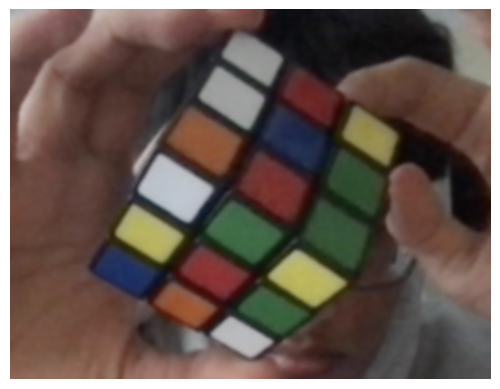

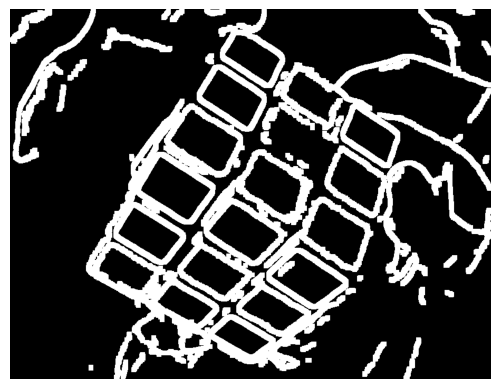

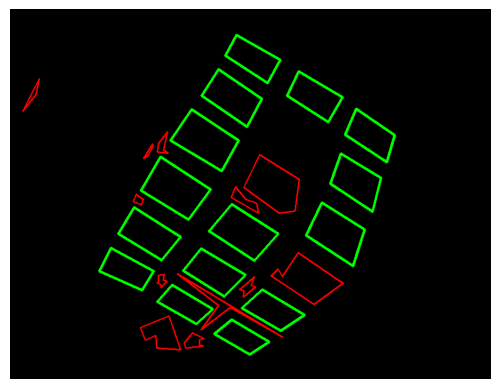

In [125]:
def filter_cubie_contours(img: cv2.Mat, contours: list[Contour], approx: list[Contour]) -> list[Contour]:

    # filter erradic, non-quadrilateral contours
    proper_contours, proper_approx = [], []
    for cnt, appr in zip(contours, approx):

        # make sure the shape approximation is a quadrilateral 
        D = len(appr) * 2
        if not 8==D:  # lol
            continue

        # make sure the approx isnt crazy different area-wise - consider removing this test
        cnt_area = cv2.contourArea(cnt)
        ratio = cnt_area / cv2.contourArea(appr)
        if min(ratio, 1/ratio) < 0.80:   # artitrary ratio thresold chosen by me
            continue

        # make sure the overlapping area isnt too bad
        overlap_reference = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.drawContours(overlap_reference, [cnt], -1, (255, 255, 255), cv2.FILLED)
        cv2.drawContours(overlap_reference, [appr], -1, (0, 0, 0), cv2.FILLED)
        if (overlap_reference.sum() // 255) > (cnt_area // 5):
            continue

        proper_contours.append(cnt) 
        proper_approx.append(appr)

    # sweep through it again and cut off the ones that are too small
    avg_area = np.average([*map(cv2.contourArea, proper_approx)])
    largest_approx = [*filter(lambda x: cv2.contourArea(x) > avg_area / 4, proper_approx)]

    # this time, give each contour a consistent ordering, making it start from the leftmost if possible else bottommost
    final_approx = []
    for appr in largest_approx:
        x_axis_vals = [*map(lambda x: x[0], appr)]
        max_index = np.argsort(x_axis_vals)
        if x_axis_vals[max_index[1]] - x_axis_vals[max_index[0]] < img.shape[1] / 18:
            y_axis_vals = [*map(lambda x: x[1], appr)]
            max_index = np.argsort(y_axis_vals)
        final_approx.append(np.concatenate((appr[max_index[0]:], appr[:max_index[0]]), axis=0))
    return final_approx 

def get_cubie_contours(img: cv2.Mat, show: bool = False) -> list[Contour]:

    # computes some sizes - doesn't get too crazy because sizes are standardized
    reference_size = max(img.shape)
    blur_size = int(sqrt(reference_size) / 2)
    kernel_size = int(sqrt(reference_size) / 10)
    if show:
        print(reference_size, blur_size, kernel_size)

    # image processing to get contours
    blur = cv2.GaussianBlur(img, (blur_size + int(blur_size % 2 == 0),) * 2, kernel_size)
    edges = cv2.Canny(blur, 20, 30)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size * 3,) * 2)
    dilated = cv2.dilate(edges, kernel)
    contours = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    large_contours = [*filter(lambda x: cv2.contourArea(x, True) > (img.shape[0] * img.shape[1]) // 5000, contours)]
    approx = [*map(lambda x: cv2.approxPolyDP(x, 0.03*cv2.arcLength(x, True), True).reshape(-1, 2), large_contours)]
    
    # filter the contours, show if needed
    filtered = filter_cubie_contours(img, large_contours, approx)
    if show:
        display_image = np.zeros_like(img)
        cv2.drawContours(display_image, approx, -1, (0, 0, 255), 2)
        cv2.drawContours(display_image, filtered, -1, (0, 255, 0), 3)
        imshow(blur, dilated, display_image)
    return filtered

img = imread_capped("./images/test2.png")
_ = get_cubie_contours(img, show=True)

Split the small cubies by face, in order to better determine where everything is - this works optimally when the cube has three faces on display, as all three have different angles.

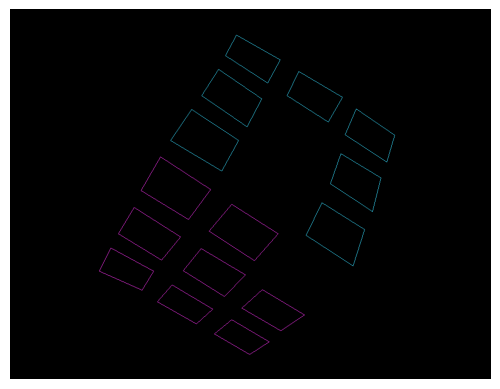

In [128]:
ANGLE_DIFF_TOLERANCE = 30   # degrees

def get_squares_by_angle(squares: list[Contour], show: bool = False) -> dict[tuple[float], list[Contour]]:
    """ Returns a map of angle-pairs to a list of contours. This is done to seperate them into faces. """
    angle_to_squares = {}
    for appr in squares:
        appr = appr.reshape(-1, 2)
        corner1, corner2, corner3 = appr[0], appr[1], appr[-1]
        angle_of_incline1 = compute_incline_angle(corner1, corner2)
        angle_of_incline2 = compute_incline_angle(corner3, corner1)
        for (k1, k2), v in angle_to_squares.items():
            if abs(angle_of_incline1 - k1) < ANGLE_DIFF_TOLERANCE and abs(angle_of_incline2 - k2) < ANGLE_DIFF_TOLERANCE:

                # add to list of contours 
                v.append(appr)
                current_total = len(v) - 1

                # replace the key with the new average
                del angle_to_squares[(k1, k2)]
                angle_to_squares[((k1 * current_total + angle_of_incline1) / (current_total + 1), 
                                  (k2 * current_total + angle_of_incline2) / (current_total + 1))] = v
                break
        else:
            angle_to_squares[(angle_of_incline1, angle_of_incline2)] = [appr]

    # raise a red flag if only one side was detected -- assuming the user did everything correctly, this incicates the unique case
    if len(angle_to_squares) == 1:

        # we need to split the cube into two parts, across a diagonal line
        pivot_point = (400, 400)
        average_angle = radians(np.average([compute_incline_angle(c1, c2) for (c1, c2, _, _) in squares]))
        rotated_centers = [get_rotated_point(pivot_point, get_center(appr), -average_angle) for appr in squares]
        if ((max_y := max(map(lambda x: x[1], rotated_centers))) - (min_y := min(map(lambda x: x[1], rotated_centers))) > 
            (max_x := max(map(lambda x: x[0], rotated_centers))) - (min_x := min(map(lambda x: x[0], rotated_centers)))):
            midline = (max_y + min_y) / 2
            comp_function = lambda x: x[1]
        else:
            midline = (max_x + min_x) / 2
            comp_function = lambda x: x[0]
        group_lower = [c for c, rc in zip(squares, rotated_centers) if comp_function(rc) < midline]
        group_upper = [c for c, rc in zip(squares, rotated_centers) if comp_function(rc) > midline]
        angle_to_squares = {  # the angle choice here doesn't really matter
            (0, 0): group_lower,
            (69, 69): group_upper
        }

    # show if needed
    if show:
        display_img = np.zeros_like(img)
        for i, v in enumerate(angle_to_squares.values()):
            colors = ((235, 204, 52), (226, 49, 232), (65, 217, 48), (0, 0, 200))
            cv2.drawContours(display_img, v, -1, colors[min(i, 3)], max(display_img.shape) // 1000 + 1)
        imshow(display_img)
    return angle_to_squares

img = imread_capped("./images/test2.png")
_ = get_squares_by_angle(get_cubie_contours(img), show=True)

Considering restricting input to only allow for three-sided images

- Current ideas:
    - This is using the three-face strategy
    - Find the top-most piece in the cube, interpolate the locations of the other pieces
        - Ask user to hold the cube so that a tip is on the top and bottom, making sure that each extreme is on the top or bottom
    - Keep the faces unique, then we can make a map of faces to cubes
- Alernative ideas:
    - Make the user go through three different positions of showing just two parts of the cube.
        - i.e. front and right, top and left, etc
    - Then, see the top pieces and the bottom pieces
    - See if we can implement all the things    

## Method 1 - Prefered because cooler

Assume there is a lot of squares... from that it is possible to find the extreme areas to place things on

Form a grid, as grace was saying

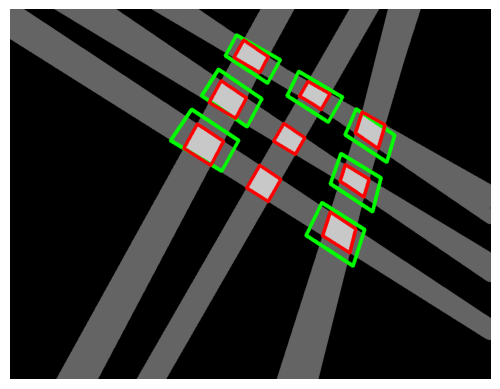

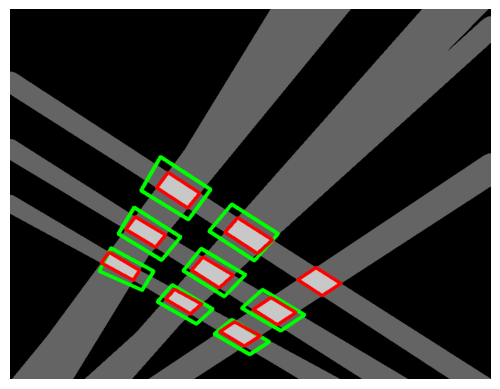

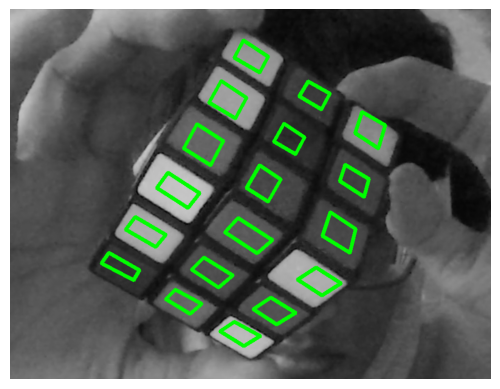

In [129]:
# https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html

def fill_line_through_contour(intersection_map: cv2.Mat, center: Point, mid_corner: Point, ang_ref_corner: Point, thick_ref_corner: Point) -> None:
    """ Draws a thick line through a contour on a given image using given reference points """

    # determine angles for use later
    line_angle = radians(compute_incline_angle(mid_corner, ang_ref_corner))
    thick_ref_angle = radians(compute_incline_angle(mid_corner, thick_ref_corner))

    # compute locations of bounding points by extrapolating using the angle   -- TODO: consider changing the angle to be the average angle at that spot, eliminate noise
    point1 = (0, tan(line_angle)*center[0] + center[1])
    point2 = (intersection_map.shape[1], -tan(line_angle)*(intersection_map.shape[1]-center[0]) + center[1])

    # determine the thickness using the angle of difference in the parallelogram, and plot to the map
    thickness = int(dist(mid_corner, thick_ref_corner) * abs(sin(thick_ref_angle - line_angle)))
    cv2.line(intersection_map, [*map(int, point1)], [*map(int, point2)], 100, thickness // 2)  # thickness is adjusted to avoid potential overlap of squares

def fill_empty_squares(img: cv2.Mat, face_contours: dict[tuple[float], list[Contour]], show: bool = False):

    new_face_contours = {}
    for key, squares in face_contours.items():

        # fill intersection maps for each deteced piece, showing all possible pieces
        c1_c2_intersection_map = np.zeros(img.shape[:2], dtype=np.uint8)
        c2_c3_intersection_map = np.zeros(img.shape[:2], dtype=np.uint8)
        for cnt in squares:
            center = get_center(cnt)
            c1, c2, c3 = cnt[:-1]
            fill_line_through_contour(c1_c2_intersection_map, center, c2, c3, c1)
            fill_line_through_contour(c2_c3_intersection_map, center, c2, c1, c3)
        
        # determine a final map and new contours that are completely accurate to the cube
        final_map = c1_c2_intersection_map + c2_c3_intersection_map
        thresh = cv2.threshold(final_map, 199, 255, cv2.THRESH_BINARY)[1]
        new_squares = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
        new_approx = [*map(lambda x: cv2.approxPolyDP(x, 0.03*cv2.arcLength(x, True), True).reshape(-1, 2), new_squares)]  # reshape makes it from (-1, 1, 2) to (-1, 2)
        new_face_contours[key] = [*filter(lambda x: len(x) == 4 and cv2.contourArea(x) > np.prod(img.shape[:2]) // 2000, new_approx)]

        # show the map, green is original contours, red is the new ones
        if show:
            display_img = cv2.cvtColor(final_map, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(display_img, squares, -1, (0, 255, 0), 5)
            imshow(cv2.drawContours(display_img, new_squares, -1, (0, 0, 255), 5))

    # show the final piece determinations
    if show:
        disp_img = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
        for contours in new_face_contours.values():
            cv2.drawContours(disp_img, contours, -1, (0, 255, 0), 5)
        imshow(disp_img)

    return new_face_contours

img = imread_capped("./images/test2.png")
_ = fill_empty_squares(img, get_squares_by_angle(get_cubie_contours(img)), show=True)

In [104]:
from enum import Enum
class FaceLocation(Enum):
    """ Quick enum to store information regarding where the faces are on the cube """
    TOP = 0
    BOTTOM = 1
    LEFT = 2
    RIGHT = 3

Alternate approach here to think about:
- Find lines between each point 
- For each line, go through each other line and calculate the intersections (time complexity of about n^4 where n is the side length of the cube - 4^4 = 16^2 = 256 which isn't that bad) 
- Determine the average location of each intersection point and use it as the main reference 
- Then determine the other stuff eetc.

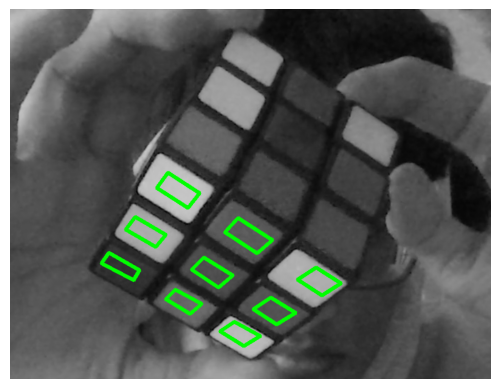

In [110]:
def get_squares_by_face(face_contours: dict[tuple[float], list[Contour]]) -> dict[FaceLocation, list[Contour]]:
    
    # remove blank keys
    for key, squares in face_contours.items():
        if not squares:
            del face_contours[key]

    # check if the number if face contours is 0, if so, we only have two options
    if len(face_contours) < 2:
        raise ComputerVisionException("Too few faces detected.")
    elif len(face_contours) > 3:
        raise ComputerVisionException("Too many faces detected.")
    elif len(face_contours) == 2:

        # determine average angle of going top 
        top_right_angle = 0
        for key, squares in face_contours.items():
            left_most_indices = [np.argsort([*map(lambda x: x[0], cnt)])[0] for cnt in squares]
            angle_points = [[cnt[i], cnt[(i-1) % 4]] for cnt, i in zip(squares, left_most_indices)]
            top_right_angle += np.average([compute_incline_angle(left, top) for left, top in angle_points])
        top_right_angle = np.radians(top_right_angle / 2)

        # determine the left_most contour 
        pivot_point = (400, 400)  # arbitrary - relative locations remain the same
        rotated_face_contours = {
            k: [[get_rotated_point(pivot_point, p, -top_right_angle) for p in cnt] for cnt in squares]
            for k, squares in face_contours.items()
        }

        # determine if the contours are significantly above or below each other
        key_1, key_2 = face_contours.keys()
        center_of_mass_1, center_of_mass_2 = map(lambda k: np.average([get_center(np.array(cnt)) for cnt in rotated_face_contours[k]], axis=0), [key_1, key_2])
        if len({center_of_mass_1[0] > get_center(np.array(cnt))[0] for cnt in rotated_face_contours[key_2]}) == 1:  # the key1 is more to the left or right than key

            # here, we make sure key_1 is always the leftmost key for returning
            if center_of_mass_2[0] < center_of_mass_1[0]:
                key_1, key_2 = key_2, key_1
            return {
                FaceLocation.BOTTOM: face_contours[key_1],
                FaceLocation.RIGHT: face_contours[key_2]
            }
        
        # now we know it's the other scenario -- once again, we make sure key_1 is the top_most key
        else:
            if center_of_mass_2[1] < center_of_mass_1[1]:
                key_1, key_2 = key_2, key_1
            return {
                FaceLocation.LEFT: face_contours[key_1],
                FaceLocation.BOTTOM: face_contours[key_2]
            }
        
    elif len(face_contours) == 3:
        left_right_keys, center_of_masses, left_right_side_points = [], {}, {}
        for key, squares in face_contours.items():

            # storing left-side points and right-side points for each contour
            sorted_left_to_right = [sorted(cnt, key=lambda p: p[0]) for cnt in squares]
            left_side_points = [sorted(points[:2], key=lambda p: p[1]) for points in sorted_left_to_right]    # sorting these two top to bottom for consistency
            right_side_points = [sorted(points[2:], key=lambda p: p[1]) for points in sorted_left_to_right]
            left_right_side_points[key] = (left_side_points, right_side_points)

            # get the average angle figured out, if its pretty much vertical its on the left/right face
            angles = [compute_incline_angle(*points) % 180 for points in left_side_points + right_side_points]
            if 60 < np.average(angles) < 120 and np.std(angles) < 20:  # this means we have detected a mostly vertical angle group
                left_right_keys.append(key)

            # determine the center of mass for the things
            center_of_mass = np.average([get_center(cnt) for cnt in squares], axis=0)
            center_of_masses[key] = center_of_mass

        # determine the left key from looking at where the center is 
        left_key, right_key = sorted(left_right_keys, key=lambda k: center_of_masses[k][0])

        # meaning: left_right means the left face, right line. we are checking if the left face right line is higher/lower than the left face left line
        left_left_avg, left_right_avg, right_left_avg, right_right_avg = map(
            lambda points_group: np.array([np.average([*map(lambda x: x[1], points)]) for points in points_group]), [
                left_right_side_points[left_key][0], left_right_side_points[left_key][1], 
                left_right_side_points[right_key][0], left_right_side_points[right_key][1]
            ]
        )
        total_diff = np.average(left_left_avg - left_right_avg) + np.average(right_right_avg - right_left_avg)
        top_or_bottom_face_loc = FaceLocation.BOTTOM if total_diff > 0 else FaceLocation.TOP
        top_or_bottom_key = (set(face_contours.keys()) - {left_key, right_key}).pop()

        # construct final dict
        return {
            face_loc: face_contours[key]
            for face_loc, key in zip(
                [FaceLocation.LEFT, FaceLocation.RIGHT, top_or_bottom_face_loc],
                [left_key, right_key, top_or_bottom_key]
            )
        }

img = imread_capped("./images/test2.png")
new_square_contours = fill_empty_squares(img, get_squares_by_angle(get_cubie_contours(img)))
squares_by_face = get_squares_by_face(new_square_contours)
display_img = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
imshow(cv2.drawContours(display_img, squares_by_face[FaceLocation.BOTTOM], -1, (0, 255, 0), 5))

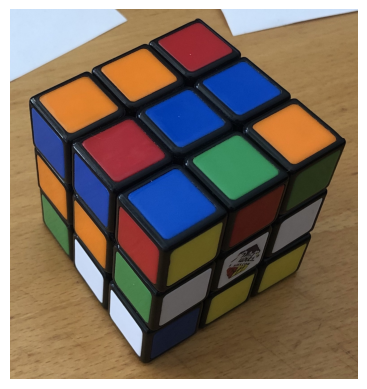

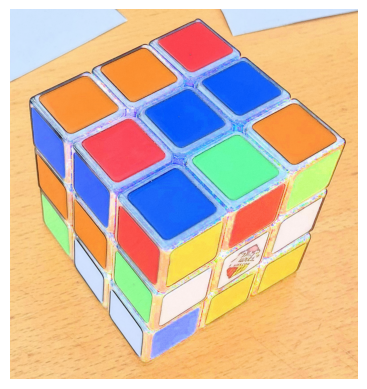

In [106]:
def get_extreme_diff(channel: np.ndarray) -> np.ndarray:
    dilated = cv2.dilate(channel, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
    bg = cv2.medianBlur(dilated, 21)
    diff = 255 - cv2.absdiff(channel, bg) 
    return cv2.normalize(diff, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

def remove_shadows(img: cv2.Mat) -> cv2.Mat:
    hsv_img = to_hsv(img)
    h, s, v = cv2.split(hsv_img)
    new_img = cv2.merge([h, s, get_extreme_diff(v)])
    return from_hsv(new_img)

img = cv2.imread("./images/cube_ugly.png")
imshow(img, remove_shadows(img))

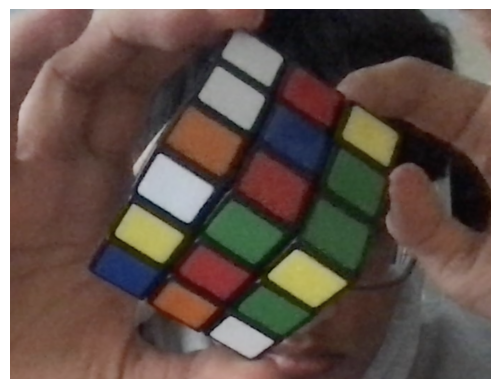

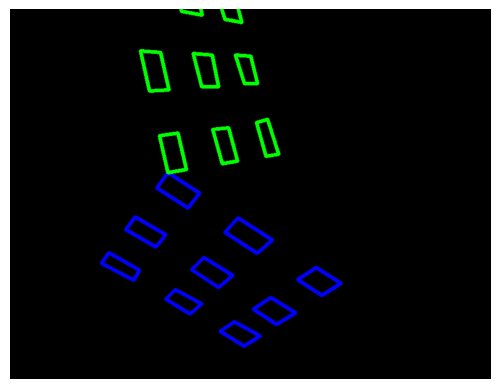

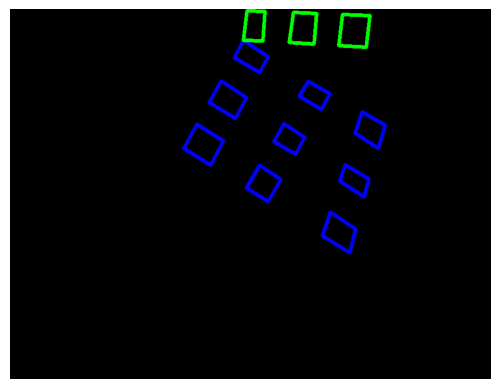

{<FaceLocation.BOTTOM: 1>: array([[<Color.YELLOW: 5>, <Color.GREEN: 0>, None],
        [<Color.GREEN: 0>, None, <Color.ORANGE: 1>],
        [None, <Color.YELLOW: 5>, <Color.BLUE: 2>]], dtype=object),
 <FaceLocation.RIGHT: 3>: array([[<Color.YELLOW: 5>, <Color.GREEN: 0>, <Color.GREEN: 0>],
        [<Color.RED: 3>, <Color.BLUE: 2>, <Color.RED: 3>],
        [<Color.WHITE: 4>, None, <Color.ORANGE: 1>]], dtype=object)}

In [135]:
HSV_FILTER_COLORS = {
    Color.RED: (((170, 180), (0, 5)), (100, 255), (100, 255)),
    Color.ORANGE: (((5, 20),), (100, 255), (100, 255)),
    Color.BLUE: (((95, 125),), (100, 255), (100, 255)),
    Color.GREEN: (((40, 75),), (50, 255), (50, 255)),
    Color.WHITE: (((0, 180),), (0, 50), (150, 255)),
    Color.YELLOW: (((20, 35),), (100, 255), (100, 255)),
}

# TODO: maybe fix this method so that it is more flexible to different shades
def get_color(img: cv2.Mat, p: Point) -> Color:
    [[hsv_point]] = cv2.cvtColor(np.array([[img[p[1], p[0]]]], dtype=np.uint8), cv2.COLOR_BGR2HSV)
    for color, (h_ranges, *other_ranges) in HSV_FILTER_COLORS.items():
        for h_range in h_ranges:
            if all([x > x_range[0] and x < x_range[1] for x, x_range in zip(hsv_point, [h_range, *other_ranges])]):
                return color
    return None

def determine_face_colors(img: cv2.Mat, squares_by_face: dict[FaceLocation, list[Contour]], show: bool = False) -> dict[FaceLocation, np.ndarray[Color]]:
    
    N = sqrt(max(map(len, squares_by_face.values())))
    if N != (N := int(N)):
        raise ComputerVisionException("Invalid cube detected. Squares per side is not a perfect square.")
    face_to_colors = {}
    for face, squares in squares_by_face.items():

        # skip if bad square read
        if not sqrt(len(squares)) == N:
            continue
        
        # let the pivot point be the top-most corner of the cube, and find an arbitrary average angle to straighten by 
        pivot_point = min([min(cnt, key=lambda x: x[1]) for cnt in squares], key=lambda x: x[1])
        angles = [compute_incline_angle(*cnt[:2]) for cnt in squares]
        if np.std(angles) > 30:
            second_try_squares = []
            for cnt in squares:
                x_axis_vals = [*map(lambda x: x[0], cnt)]
                max_index = np.argsort(x_axis_vals)
                if x_axis_vals[max_index[1]] - x_axis_vals[max_index[0]] < img.shape[1] / 18:
                    y_axis_vals = [*map(lambda x: x[1], cnt)]
                    max_index = np.argsort(y_axis_vals)
                second_try_squares.append(np.concatenate((cnt[max_index[0]:], cnt[:max_index[0]]), axis=0))
            angles = [compute_incline_angle(*cnt[:2]) for cnt in second_try_squares]
        average_angle = radians(np.average(angles))

        # calculate new, rotated images to use, show if needed 
        new_contours = np.array([[get_rotated_point(pivot_point, p, -average_angle) for p in cnt] for cnt in squares])
        if show:
            disp_img = np.zeros_like(img)
            cv2.drawContours(disp_img, squares, -1, (255, 0, 0), 5)
            imshow(cv2.drawContours(disp_img, new_contours, -1, (0, 255, 0), 5))

        # sort the centers top to bottom, then insert the address of each contour into the thing
        centers_with_index = [(i, get_center(cnt)) for i, cnt in enumerate(new_contours)]
        sorted_centers = sorted(centers_with_index, key=lambda x: x[1][1])
        face_contour_map = [[
            index_point_pair[0] for index_point_pair in
            sorted(sorted_centers[N*i:N*(i+1)], key=lambda x: x[1][0])
        ] for i in range(N)]
        
        # now that we have determined what indeces of the squares list to look at, we can determine the color at each place
        face_to_colors[face] = np.array([[
            get_color(img, get_center(squares[face_contour_map[i][j]]))
            for j in range(N)
        ] for i in range(N)])
    return face_to_colors

img = imread_capped("./images/test2.png")
new_square_contours = fill_empty_squares(img, get_squares_by_angle(get_cubie_contours(img)))
squares_by_face = get_squares_by_face(new_square_contours)
imshow(img)
determine_face_colors(remove_shadows(img), squares_by_face, show=True)

What we need to do:
- If 2 -> 1 -> 3
-    a -> b -> a
- Else if 2 --> 1 --> 1 --> 2
-         a --> b --> a --> b

What we can do:
- when moving back to a from b, we recover the old count.
- therefore, now when going from a to b again, there is no going back again
- we progress as usual when going onto b
- we can also store the old, saved count from going back to a, adding that on when going to b

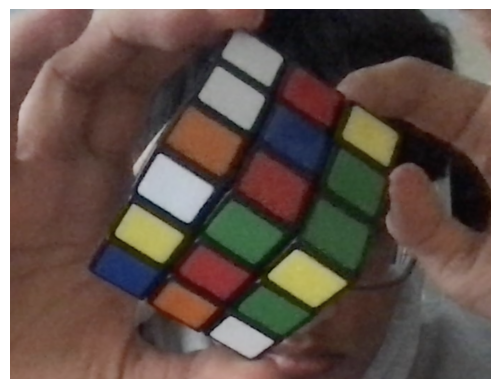

In [136]:
class ImageToCube:

    # we must spend at least these frames on a new orientation to consider it individual 
    MIN_RUN_COUNT = 3
    ROTATION_ORDER: list[tuple[dict[FaceLocation, tuple[Face, int]]]] = [
        {FaceLocation.TOP: (Face.TOP, -1), FaceLocation.RIGHT: (Face.RIGHT, 2), FaceLocation.LEFT: (Face.FRONT, -1)},
        {FaceLocation.BOTTOM: (Face.RIGHT, 2), FaceLocation.RIGHT: (Face.BACK, 2), FaceLocation.LEFT: (Face.TOP, -1)},
        {FaceLocation.TOP: (Face.BACK, 2), FaceLocation.RIGHT: (Face.BOTTOM, 2), FaceLocation.LEFT: (Face.RIGHT, 2)},
        {FaceLocation.BOTTOM: (Face.BOTTOM, 2), FaceLocation.LEFT: (Face.BACK, 2), FaceLocation.RIGHT: (Face.LEFT, -1)},
        {FaceLocation.TOP: (Face.LEFT, -1), FaceLocation.LEFT: (Face.BOTTOM, 2), FaceLocation.RIGHT: (Face.FRONT, -1)},
        {FaceLocation.BOTTOM: (Face.FRONT, -1), FaceLocation.LEFT: (Face.LEFT, -1), FaceLocation.RIGHT: (Face.TOP, -1)}
    ]

    def __init__(self):
        self.curr_state = 0
        self.curr_state_run_count = 0
        self.prev_state_run_count = 0
        self.top_face_present = True
        self.cube_guesses = None
        self.N = None
    
    def translate(self, img: cv2.Mat):  # assume the image is already in low res

        self.curr_state_run_count += 1

        # run through image processing process
        try:
            cubie_contours = get_cubie_contours(img)
            squares_by_angle = get_squares_by_angle(cubie_contours)
            interpolated_squares = fill_empty_squares(img, squares_by_angle)
            squares_by_face = get_squares_by_face(interpolated_squares)
            colors_by_face: dict[FaceLocation, list[list[Color]]] = determine_face_colors(remove_shadows(img), squares_by_face)  # type hint to help LSP
        except ComputerVisionException:
            return
        
        # determine if making fresh guesses
        current_guess_N = len(next(iter(colors_by_face.values())))
        if self.cube_guesses is None or current_guess_N > self.N:
            self.N = current_guess_N
            self.cube_guesses = [None] * 6

        # if these two are differnet, we have moved on to a next face, or it is buggin
        if self.top_face_present ^ (FaceLocation.TOP in colors_by_face):
            if self.curr_state_run_count < ImageToCube.MIN_RUN_COUNT: 
                self.curr_state -= 1
                self.curr_state_run_count, self.prev_state_run_count = self.prev_state_run_count, self.curr_state_run_count
            else:
                self.curr_state += 1
                self.prev_state_run_count = self.curr_state_run_count
                self.curr_state_run_count = 0
            self.top_face_present = not self.top_face_present

        # read the guess
        for face_loc, (cube_face, rotation) in ImageToCube.ROTATION_ORDER[self.curr_state % 6].items():
            if not face_loc in colors_by_face:
                continue
            current_face_guess = colors_by_face[face_loc]
            current_face_guess = np.rot90(current_face_guess, rotation)
            if cube_face == Face.BOTTOM:
                current_face_guess = np.flip(current_face_guess, axis=1)
            current_face_guess = current_face_guess.reshape(self.N, self.N, 1)
            if (existing_guesses := self.cube_guesses[cube_face.value]) is not None:
                self.cube_guesses[cube_face.value] = np.concatenate((existing_guesses, current_face_guess), axis=2)
            else:
                self.cube_guesses[cube_face.value] = current_face_guess

    def create_cube(self) -> Cube:
        most_voted_guesses = [None] * 6
        for face in list(Face):
            temp_face_arr = [[None] * 3 for _ in range(self.N)]
            if self.cube_guesses[face.value] is not None:
                for i in range(self.N):
                    for j in range(self.N):
                        temp_face_arr[i][j] = mode(self.cube_guesses[face.value][i, j])
            most_voted_guesses[face.value] = np.array(temp_face_arr)
        if self.N == 3:
            return Cube3x3(scramble=most_voted_guesses)
        return Cube(self.N, scramble=most_voted_guesses)

img = imread_capped("./images/test2.png")
reader = ImageToCube()
reader.translate(img)
print(reader.create_cube())
imshow(img)

In [45]:
mode_func = np.vectorize(mode)
arr = np.array([[[1, 2, 1], [2, 2, 3], [5, 6, 5]], [[1, 6, 3], [4, 2, 2], [9, 9, 9]], [[1, 2, 3], [6, 5, 6], [4, 4, 4]]])
np.apply_over_axes(mode_func, arr, [0, 1])

TypeError: mode() takes 1 positional argument but 2 were given

###########################################################################################################################################################################################################################################################